# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [7]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.0.2)


In [8]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# Downgrade to the prior release 
!pip install cftime==1.0.4.2
# Learned this from Birk
# Website: https://github.com/pvlib/pvlib-python/issues/895

# Try to save Excel
!pip install openpyxl

In [10]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
from matplotlib import pyplot
%matplotlib inline

# Specify Location (Denver, CO)
latitude, longitude, tz = 39.7, -105.2, 'America/Denver'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=2)
irrad_vars = ['ghi','dni','dhi']

In [11]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [12]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

### Instantiate a GFS model object and get the forecast data from Unidata

In [48]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_convective_cloud  \
2020-04-22 06:00:00-06:00                                 0.0   
2020-04-22 09:00:00-06:00                                 0.0   
2020-04-22 12:00:00-06:00                                 0.0   
2020-04-22 15:00:00-06:00                                 0.0   
2020-04-22 18:00:00-06:00                                 0.0   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-04-22 06:00:00-06:00                                                0.0                
2020-04-22 09:00:00-06:00                                                0.0                
2020-04-22 12:00:00-06:00                                                0.0                
2020-04-22 15:00:00-06:00                                                0.0                
2020-04-22 18:00:00-06:00                                                0.0                

                           Temperature_surface  \


### Process Data with pvlib

In [49]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-04-22 06:00:00-06:00   4.583496    3.723207    0.000000    0.000000   
2020-04-22 09:00:00-06:00   3.066742    3.291675  411.124178  458.119851   
2020-04-22 12:00:00-06:00   1.950012    2.212731  537.504999  125.493670   
2020-04-22 15:00:00-06:00  13.239166    5.090334  316.190610   24.136529   
2020-04-22 18:00:00-06:00  22.081451    5.471852  121.297875   12.641593   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-22 06:00:00-06:00    0.000000          84.0         1.0        75.0   
2020-04-22 09:00:00-06:00  174.759461          17.0         0.0         0.0   
2020-04-22 12:00:00-06:00  428.984740          58.0         0.0         0.0   
2020-04-22 15:00:00-06:00  297.171115          91.0         0.0        87.0   
2020-04-22 18:00:00-06:00  117.112667          81.0         0.0        79.0   

                           high_clouds  
2020-04-22 06:00:00-06:00  

### GFS'S Class

In [50]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-04-22 06:00:00-06:00   4.583496    3.723207    0.000000    0.000000   
2020-04-22 09:00:00-06:00   3.066742    3.291675  411.124178  458.119851   
2020-04-22 12:00:00-06:00   1.950012    2.212731  537.504999  125.493670   
2020-04-22 15:00:00-06:00  13.239166    5.090334  316.190610   24.136529   
2020-04-22 18:00:00-06:00  22.081451    5.471852  121.297875   12.641593   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-22 06:00:00-06:00    0.000000          84.0         1.0        75.0   
2020-04-22 09:00:00-06:00  174.759461          17.0         0.0         0.0   
2020-04-22 12:00:00-06:00  428.984740          58.0         0.0         0.0   
2020-04-22 15:00:00-06:00  297.171115          91.0         0.0        87.0   
2020-04-22 18:00:00-06:00  117.112667          81.0         0.0        79.0   

                           high_clouds  
2020-04-22 06:00:00-06:00  

## Cloud Cover & Radiation

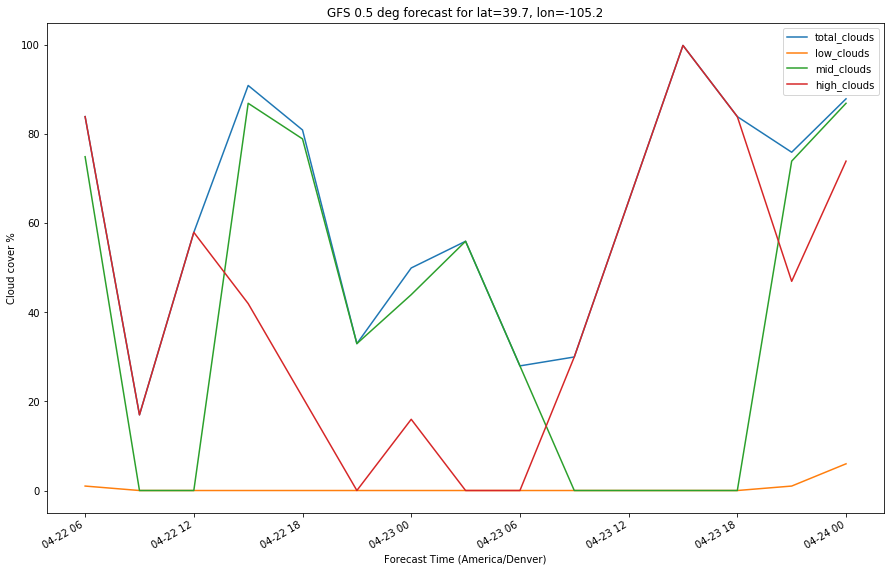

In [51]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

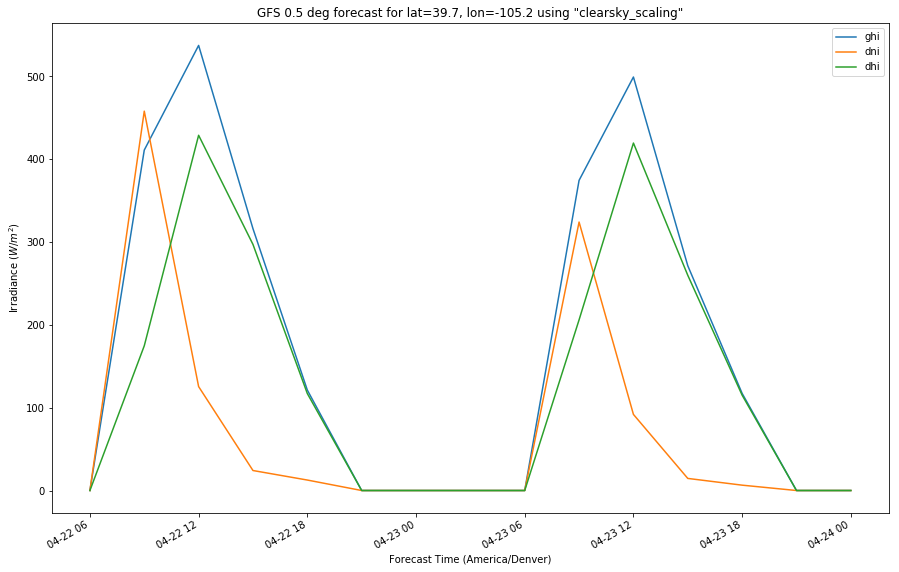

In [52]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

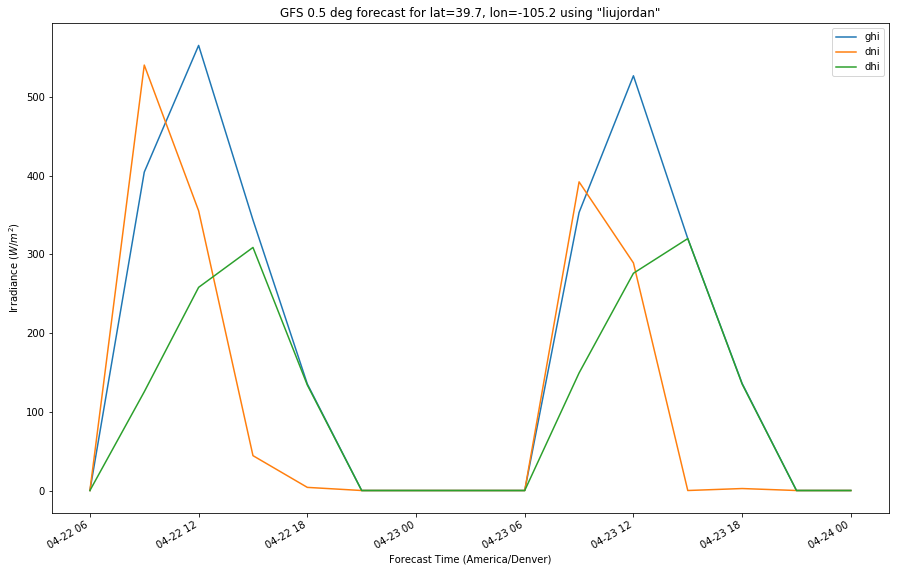

In [53]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

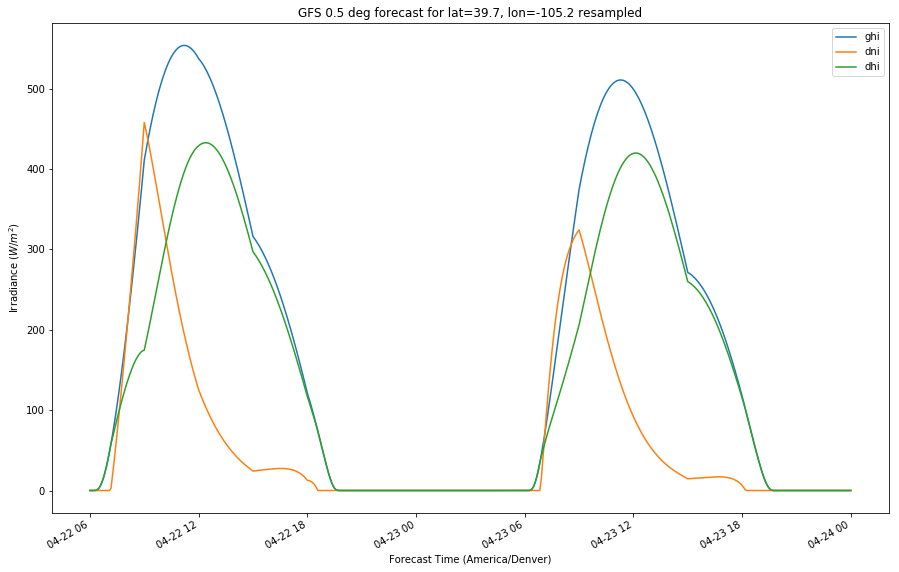

In [54]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

In [55]:
resampled_irrads

,ghi,dni,dhi
2020-04-22 06:00:00-06:00,0.000000,0.000000,0.000000
2020-04-22 06:05:00-06:00,0.000000,0.000000,0.000000
2020-04-22 06:10:00-06:00,0.000000,0.000000,0.000000
2020-04-22 06:15:00-06:00,0.011952,0.000000,0.011952
2020-04-22 06:20:00-06:00,0.240504,0.000000,0.240504
2020-04-22 06:25:00-06:00,1.077104,0.000000,1.077104
2020-04-22 06:30:00-06:00,2.929586,0.000000,2.929586
2020-04-22 06:35:00-06:00,6.022308,0.000000,6.022308
2020-04-22 06:40:00-06:00,10.396171,0.000000,10.396171
2020-04-22 06:45:00-06:00,15.988294,0.000000,15.988294


In [56]:
resampled_irrads.to_csv('5 min Irradiance.csv', encoding='utf-8')

## Weather Models
### GFS

In [57]:
# The Global Forecast System is the US model that provides forecast for the entire globe
# It is updated every six hours

### HRRR

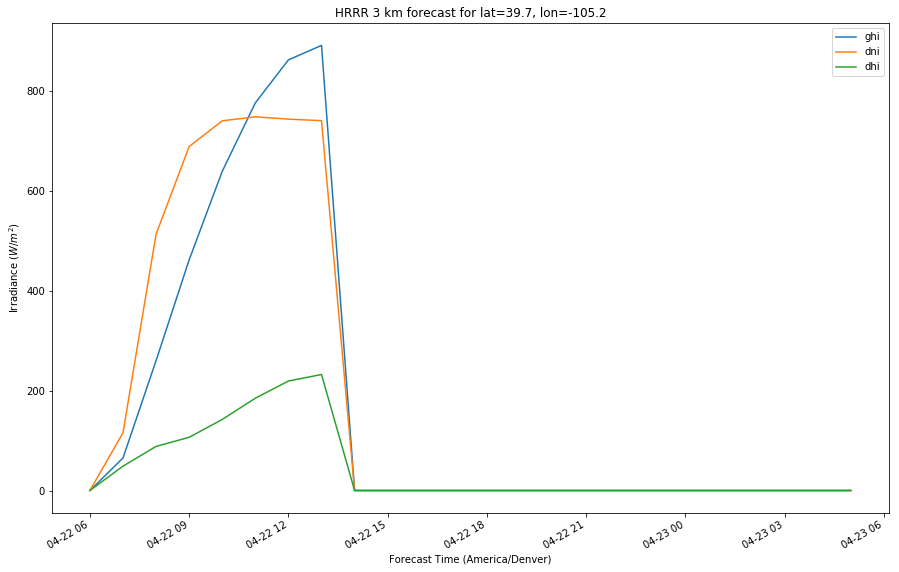

In [58]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

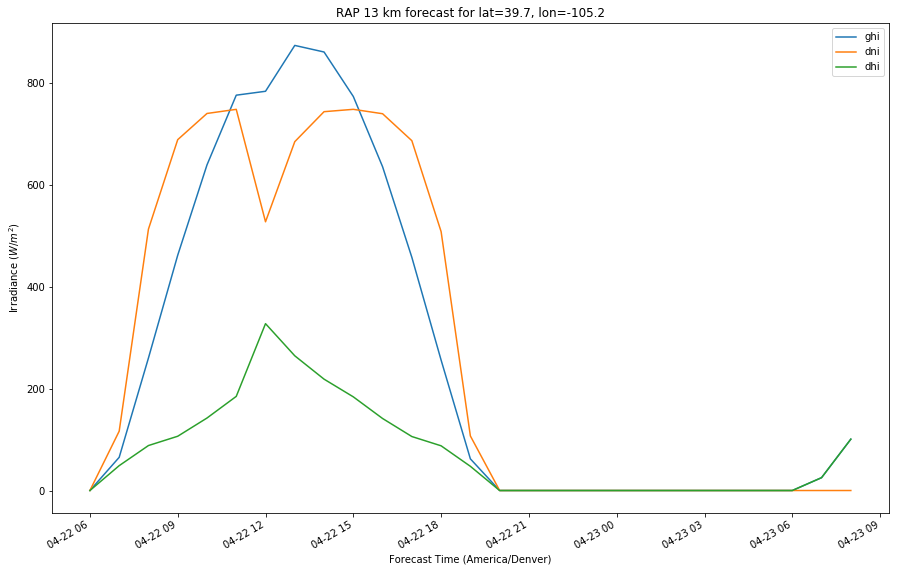

In [59]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

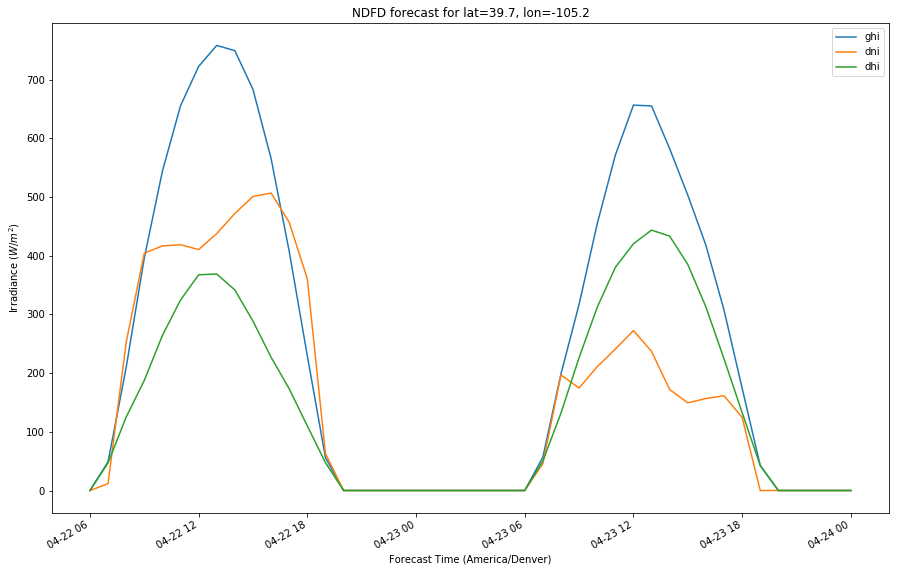

In [60]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

## PV Power Forecast

In [61]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)



ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

### ModelChain Attributes

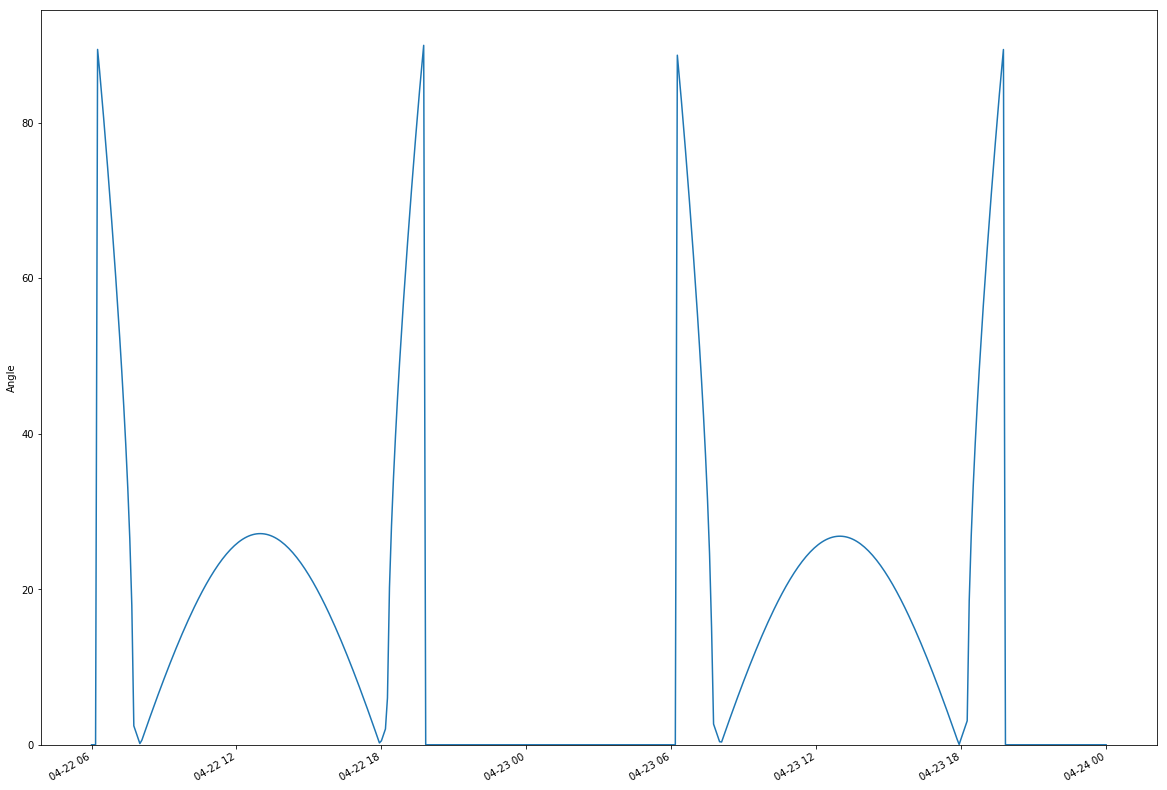

In [62]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

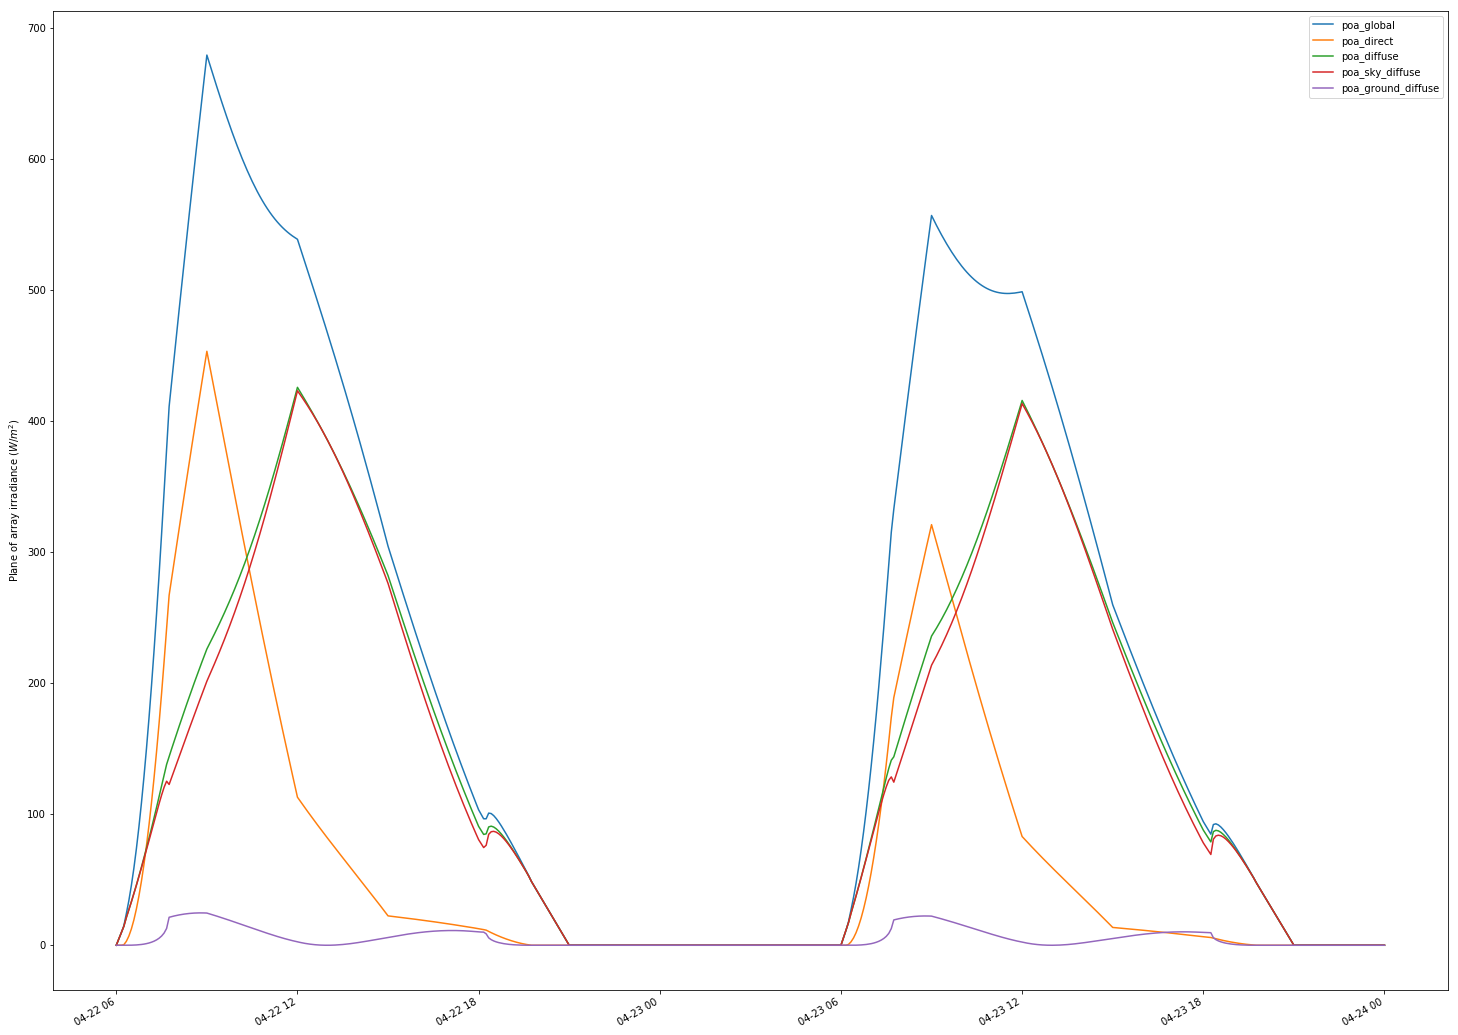

In [63]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

In [64]:
mc.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-04-22 06:00:00-06:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-04-22 06:05:00-06:00,4.808695,0.000000,4.808695,4.808695,0.000000
2020-04-22 06:10:00-06:00,9.525920,0.000000,9.525920,9.525920,0.000000
2020-04-22 06:15:00-06:00,14.792381,0.396070,14.396311,14.396183,0.000128
2020-04-22 06:20:00-06:00,24.155436,3.000817,21.154619,21.149144,0.005476
2020-04-22 06:25:00-06:00,34.122429,7.006619,27.115810,27.092019,0.023791
2020-04-22 06:30:00-06:00,45.664427,12.459576,33.204851,33.142209,0.062642
2020-04-22 06:35:00-06:00,58.882835,19.375884,39.506951,39.376796,0.130155
2020-04-22 06:40:00-06:00,73.779977,27.761525,46.018452,45.783318,0.235134
2020-04-22 06:45:00-06:00,90.354217,37.618495,52.735723,52.348378,0.387344


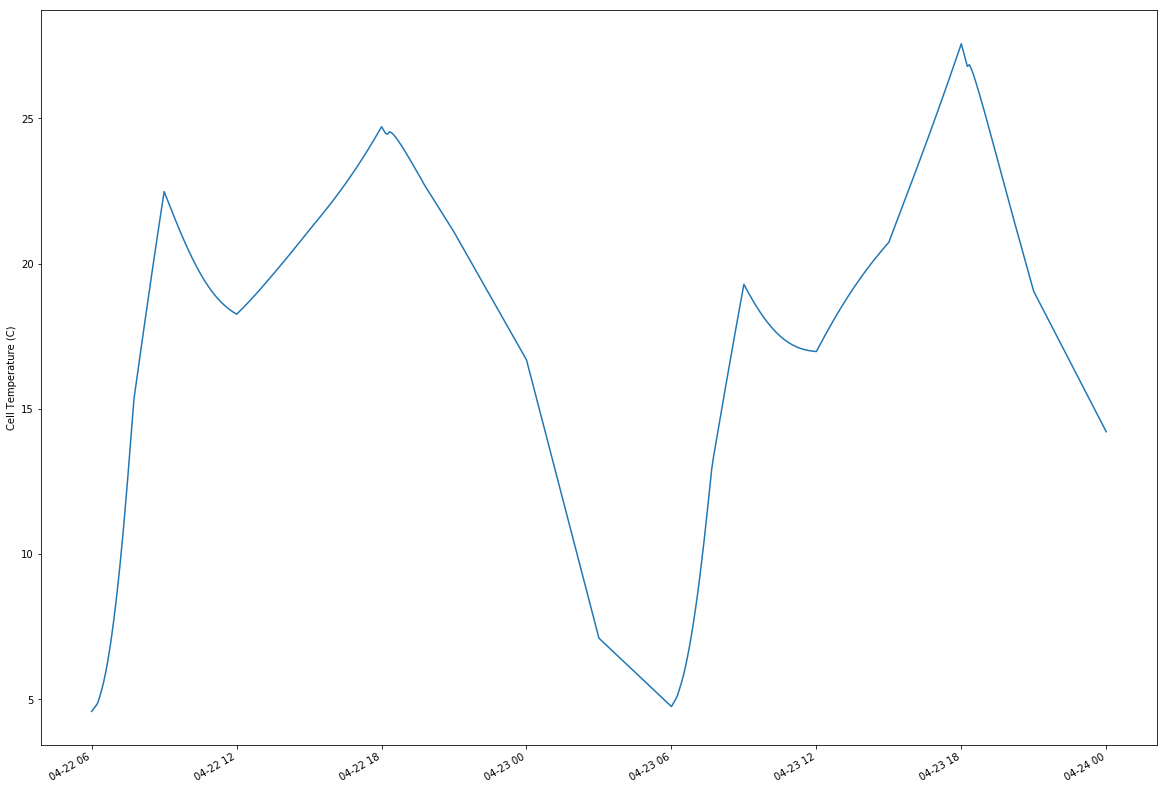

In [65]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

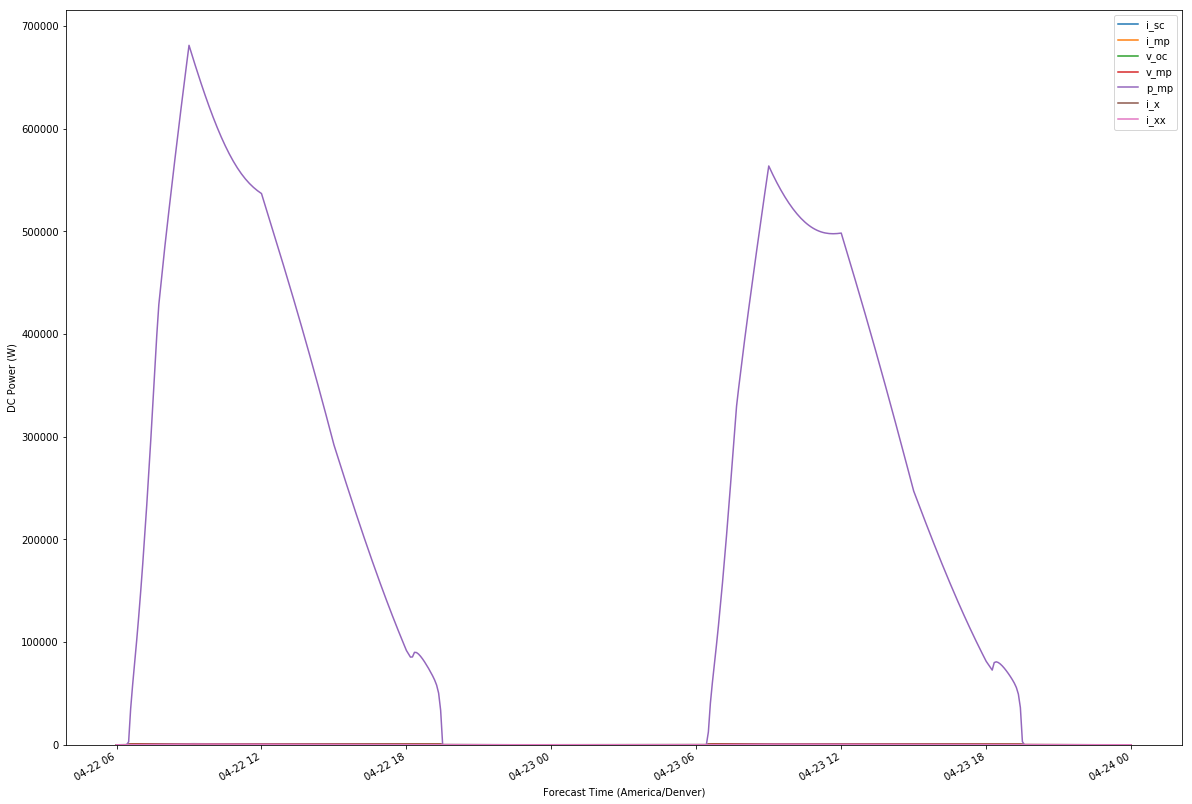

In [66]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

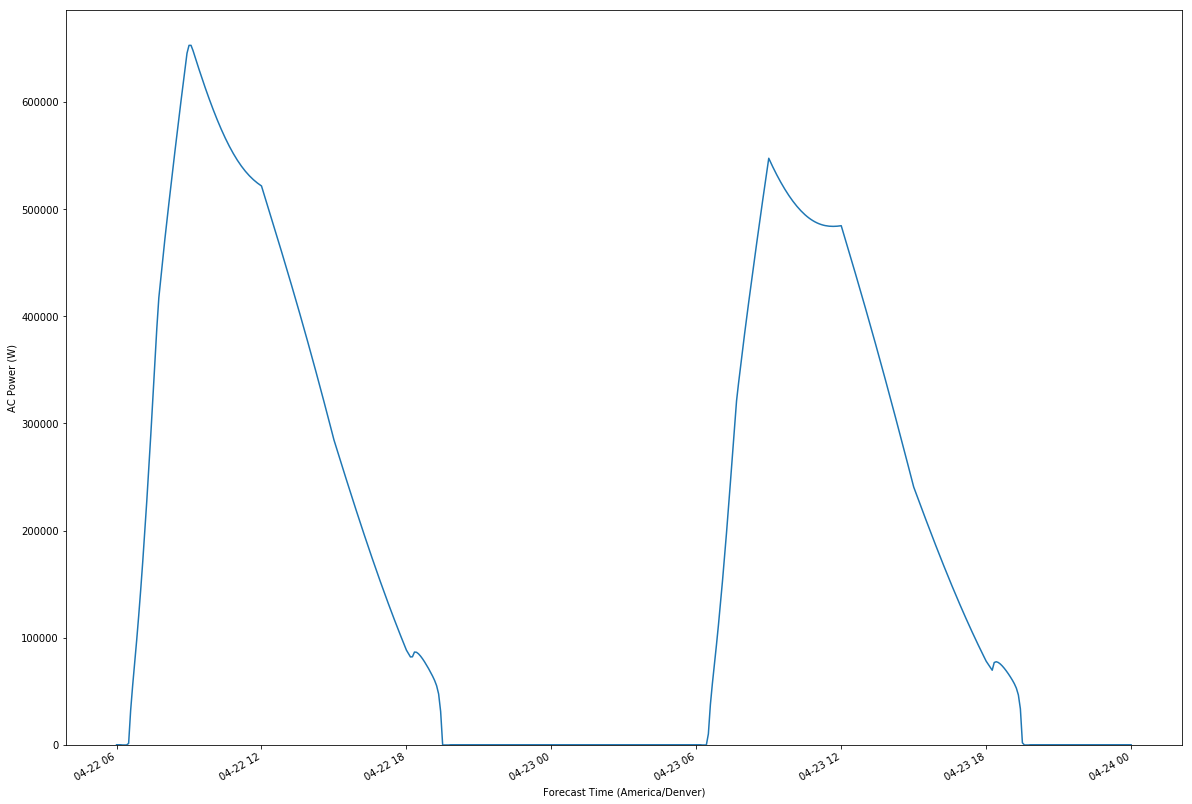

In [67]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [68]:
mc.ac.fillna(0)

2020-04-22 06:00:00-06:00         0.000000
2020-04-22 06:05:00-06:00         0.000000
2020-04-22 06:10:00-06:00         0.000000
2020-04-22 06:15:00-06:00      -195.900000
2020-04-22 06:20:00-06:00      -195.900000
2020-04-22 06:25:00-06:00      -195.900000
2020-04-22 06:30:00-06:00      1288.231461
2020-04-22 06:35:00-06:00     32069.306258
2020-04-22 06:40:00-06:00     55324.876902
2020-04-22 06:45:00-06:00     76282.490926
2020-04-22 06:50:00-06:00     97665.469645
2020-04-22 06:55:00-06:00    120409.005999
2020-04-22 07:00:00-06:00    144752.268632
2020-04-22 07:05:00-06:00    170687.258938
2020-04-22 07:10:00-06:00    198142.673312
2020-04-22 07:15:00-06:00    227054.614880
2020-04-22 07:20:00-06:00    257378.909687
2020-04-22 07:25:00-06:00    289059.826867
2020-04-22 07:30:00-06:00    321944.225816
2020-04-22 07:35:00-06:00    355588.897142
2020-04-22 07:40:00-06:00    388772.586991
2020-04-22 07:45:00-06:00    417283.480962
2020-04-22 07:50:00-06:00    435661.822033
2020-04-22 

In [69]:
mc.ac.describe()

count       326.000000
mean     311380.564192
std      191439.807993
min        -195.900000
25%      127781.206049
50%      320030.999464
75%      487016.819523
max      653000.000000
dtype: float64

In [70]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')

# NREL Data
## Wednesday & Thursday
### Irradiance & Temperature

In [69]:
# Read Irradiance & Temperature data
nrel_df = pd.read_csv('Apr 22 23 ghi dhi dni.txt')
print("Keys of nrel_df: \n{}".format(nrel_df.keys()))

Keys of nrel_df: 
Index(['DATE (MM/DD/YYYY)', 'MST', 'Global Horizontal [W/m^2]',
       'Direct Normal [W/m^2]', 'Diffuse Horizontal [W/m^2]',
       'Air Temperature [deg C]'],
      dtype='object')


In [70]:
# Columns Rename - Remove [ ]
nrel_df = nrel_df.rename(columns = {'Global Horizontal [W/m^2]': 'GHI', 'Direct Normal [W/m^2]': 'DNI', 'Air Temperature [deg C]': 'Air Temperature', 'DATE (MM/DD/YYYY)': 'DATE', 'Diffuse Horizontal [W/m^2]': 'DHI'})

In [71]:
# Analyzing Data
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
nrel_df.describe()

,GHI,DNI,DHI,Air Temperature
count,1624.000000,1624.000000,1624.000000,1624.000000
mean,366.071052,268.431545,210.153874,14.202334
std,276.302680,310.916994,132.795258,1.975970
min,2.087340,0.000000,2.087340,8.050000
25%,153.446750,0.000000,97.707950,13.090000
50%,305.889500,90.877100,202.077000,14.330000
75%,499.691500,555.158750,329.602750,15.430000
max,1212.100000,915.162000,561.403000,19.170000


In [72]:
# Columns that contain NaN values (True = Nan value)
nrel_df.isnull().any()

DATE               False
MST                False
GHI                False
DNI                False
DHI                False
Air Temperature    False
dtype: bool

In [73]:
nrel_df['Time'] = pd.to_datetime(nrel_df['MST'])

In [74]:
nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

0        5.250000
1        5.266667
2        5.283333
3        5.300000
4        5.316667
5        5.333333
6        5.350000
7        5.366667
8        5.383333
9        5.400000
10       5.416667
11       5.433333
12       5.450000
13       5.466667
14       5.483333
15       5.500000
16       5.516667
17       5.533333
18       5.550000
19       5.566667
20       5.583333
21       5.600000
22       5.616667
23       5.633333
24       5.650000
25       5.666667
26       5.683333
27       5.700000
28       5.716667
29       5.733333
          ...    
1594    18.283333
1595    18.300000
1596    18.316667
1597    18.333333
1598    18.350000
1599    18.366667
1600    18.383333
1601    18.400000
1602    18.416667
1603    18.433333
1604    18.450000
1605    18.466667
1606    18.483333
1607    18.500000
1608    18.516667
1609    18.533333
1610    18.550000
1611    18.566667
1612    18.583333
1613    18.600000
1614    18.616667
1615    18.633333
1616    18.650000
1617    18.666667
1618    18

In [75]:
nrel_df['Time Float'] = nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

In [76]:
nrel_df.rename(columns={'Time Float':'Hours', 'MST':'Time', 'Time':'MST'}, inplace=True)

In [77]:
nrel_df.head(10)

,DATE,Time,GHI,DNI,DHI,Air Temperature,MST,Hours
0,4/22/2020,05:15,6.18000,0.0,6.18000,11.05,2020-04-28 05:15:00,5.250000
1,4/22/2020,05:16,6.63186,0.0,6.63186,11.07,2020-04-28 05:16:00,5.266667
2,4/22/2020,05:17,2.90246,0.0,2.90246,11.04,2020-04-28 05:17:00,5.283333
3,4/22/2020,05:18,3.77742,0.0,3.77742,11.02,2020-04-28 05:18:00,5.300000
4,4/22/2020,05:19,4.85536,0.0,4.85536,10.97,2020-04-28 05:19:00,5.316667
5,4/22/2020,05:20,6.09196,0.0,6.09196,10.95,2020-04-28 05:20:00,5.333333
6,4/22/2020,05:21,7.59909,0.0,7.59909,10.89,2020-04-28 05:21:00,5.350000
7,4/22/2020,05:22,9.13942,0.0,9.13942,10.89,2020-04-28 05:22:00,5.366667
8,4/22/2020,05:23,10.79240,0.0,10.79240,10.89,2020-04-28 05:23:00,5.383333
9,4/22/2020,05:24,12.33710,0.0,12.33710,10.94,2020-04-28 05:24:00,5.400000


In [78]:
nrel_df.tail(10)

,DATE,Time,GHI,DNI,DHI,Air Temperature,MST,Hours
1614,4/23/2020,18:37,22.37590,0.0,22.37590,11.36,2020-04-28 18:37:00,18.616667
1615,4/23/2020,18:38,18.40060,0.0,18.40060,11.28,2020-04-28 18:38:00,18.633333
1616,4/23/2020,18:39,14.97380,0.0,14.97380,11.20,2020-04-28 18:39:00,18.650000
1617,4/23/2020,18:40,12.11380,0.0,12.11380,11.18,2020-04-28 18:40:00,18.666667
1618,4/23/2020,18:41,9.68398,0.0,9.68398,11.12,2020-04-28 18:41:00,18.683333
1619,4/23/2020,18:42,7.52061,0.0,7.52061,11.08,2020-04-28 18:42:00,18.700000
1620,4/23/2020,18:43,5.51066,0.0,5.51066,11.04,2020-04-28 18:43:00,18.716667
1621,4/23/2020,18:44,7.72576,0.0,7.72576,11.02,2020-04-28 18:44:00,18.733333
1622,4/23/2020,18:45,9.16616,0.0,9.16616,11.02,2020-04-28 18:45:00,18.750000
1623,4/23/2020,18:46,7.72676,0.0,7.72676,11.01,2020-04-28 18:46:00,18.766667


In [88]:
nrel_df = nrel_df[["DATE","MST","Time","Hours","GHI","DHI","DNI","Air Temperature"]]

In [89]:
nrel_df.head()

,DATE,MST,Time,Hours,GHI,DHI,DNI,Air Temperature
0,4/22/2020,2020-04-28 05:15:00,05:15,5.250000,6.18000,6.18000,0.0,11.05
1,4/22/2020,2020-04-28 05:16:00,05:16,5.266667,6.63186,6.63186,0.0,11.07
2,4/22/2020,2020-04-28 05:17:00,05:17,5.283333,2.90246,2.90246,0.0,11.04
3,4/22/2020,2020-04-28 05:18:00,05:18,5.300000,3.77742,3.77742,0.0,11.02
4,4/22/2020,2020-04-28 05:19:00,05:19,5.316667,4.85536,4.85536,0.0,10.97


In [90]:
nrel_df.tail()

,DATE,MST,Time,Hours,GHI,DHI,DNI,Air Temperature
1619,4/23/2020,2020-04-28 18:42:00,18:42,18.700000,7.52061,7.52061,0.0,11.08
1620,4/23/2020,2020-04-28 18:43:00,18:43,18.716667,5.51066,5.51066,0.0,11.04
1621,4/23/2020,2020-04-28 18:44:00,18:44,18.733333,7.72576,7.72576,0.0,11.02
1622,4/23/2020,2020-04-28 18:45:00,18:45,18.750000,9.16616,9.16616,0.0,11.02
1623,4/23/2020,2020-04-28 18:46:00,18:46,18.766667,7.72676,7.72676,0.0,11.01


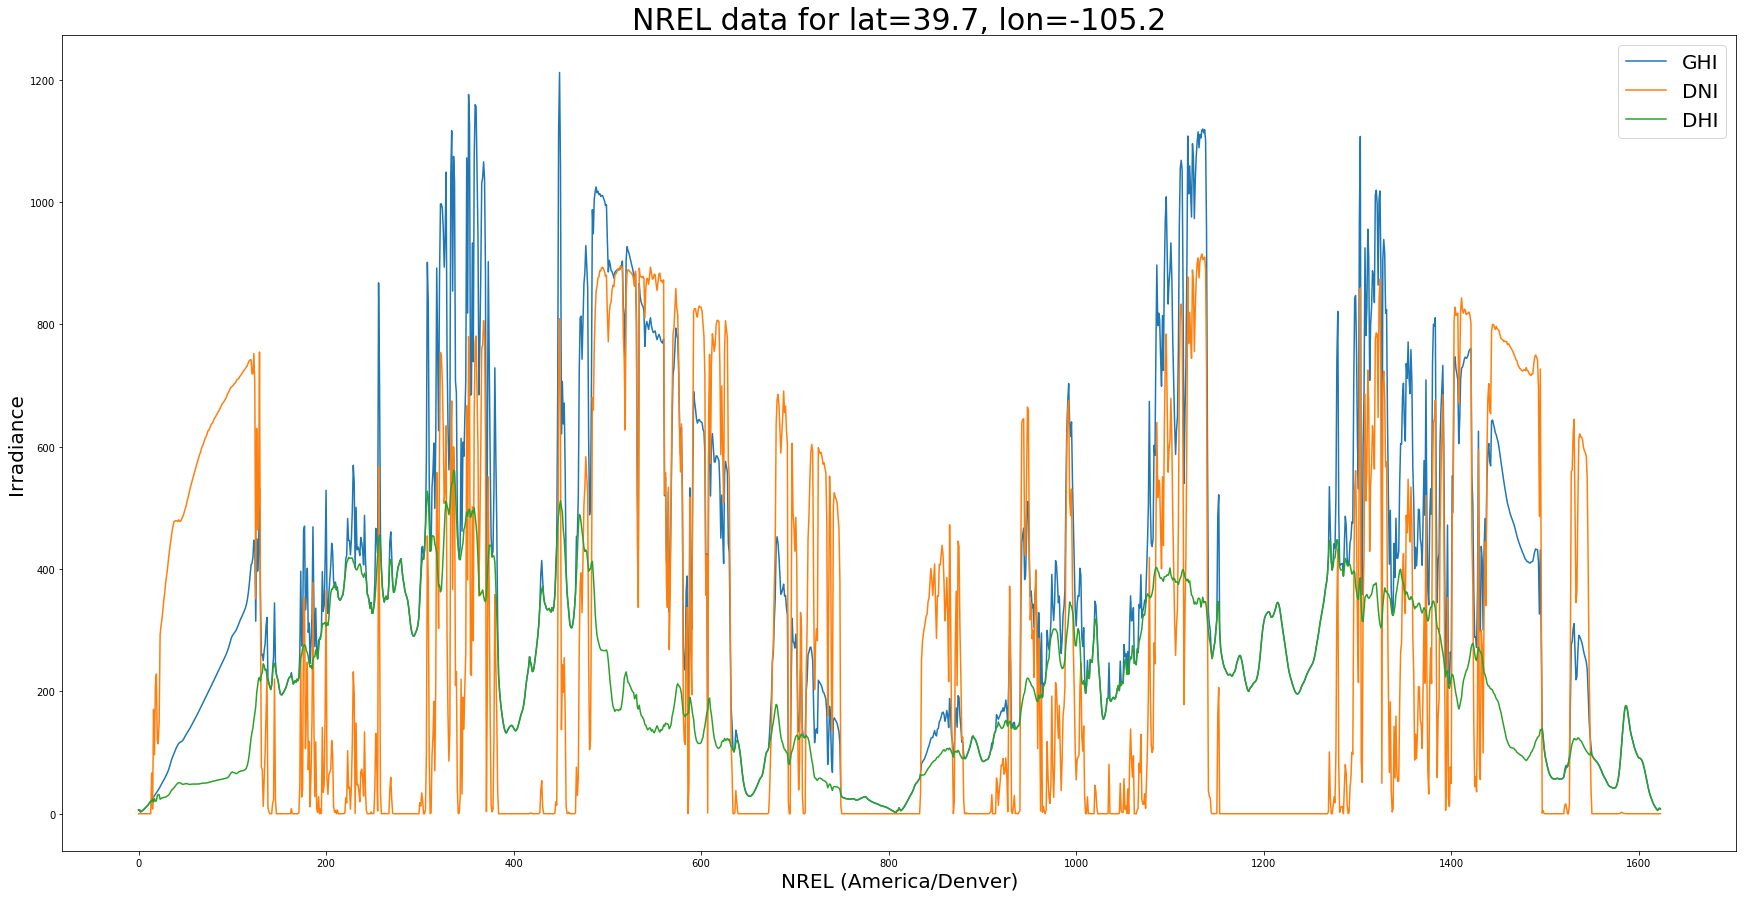

In [188]:
# Plot cloud cover percentages
irrad_var = ['GHI', 'DNI','DHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

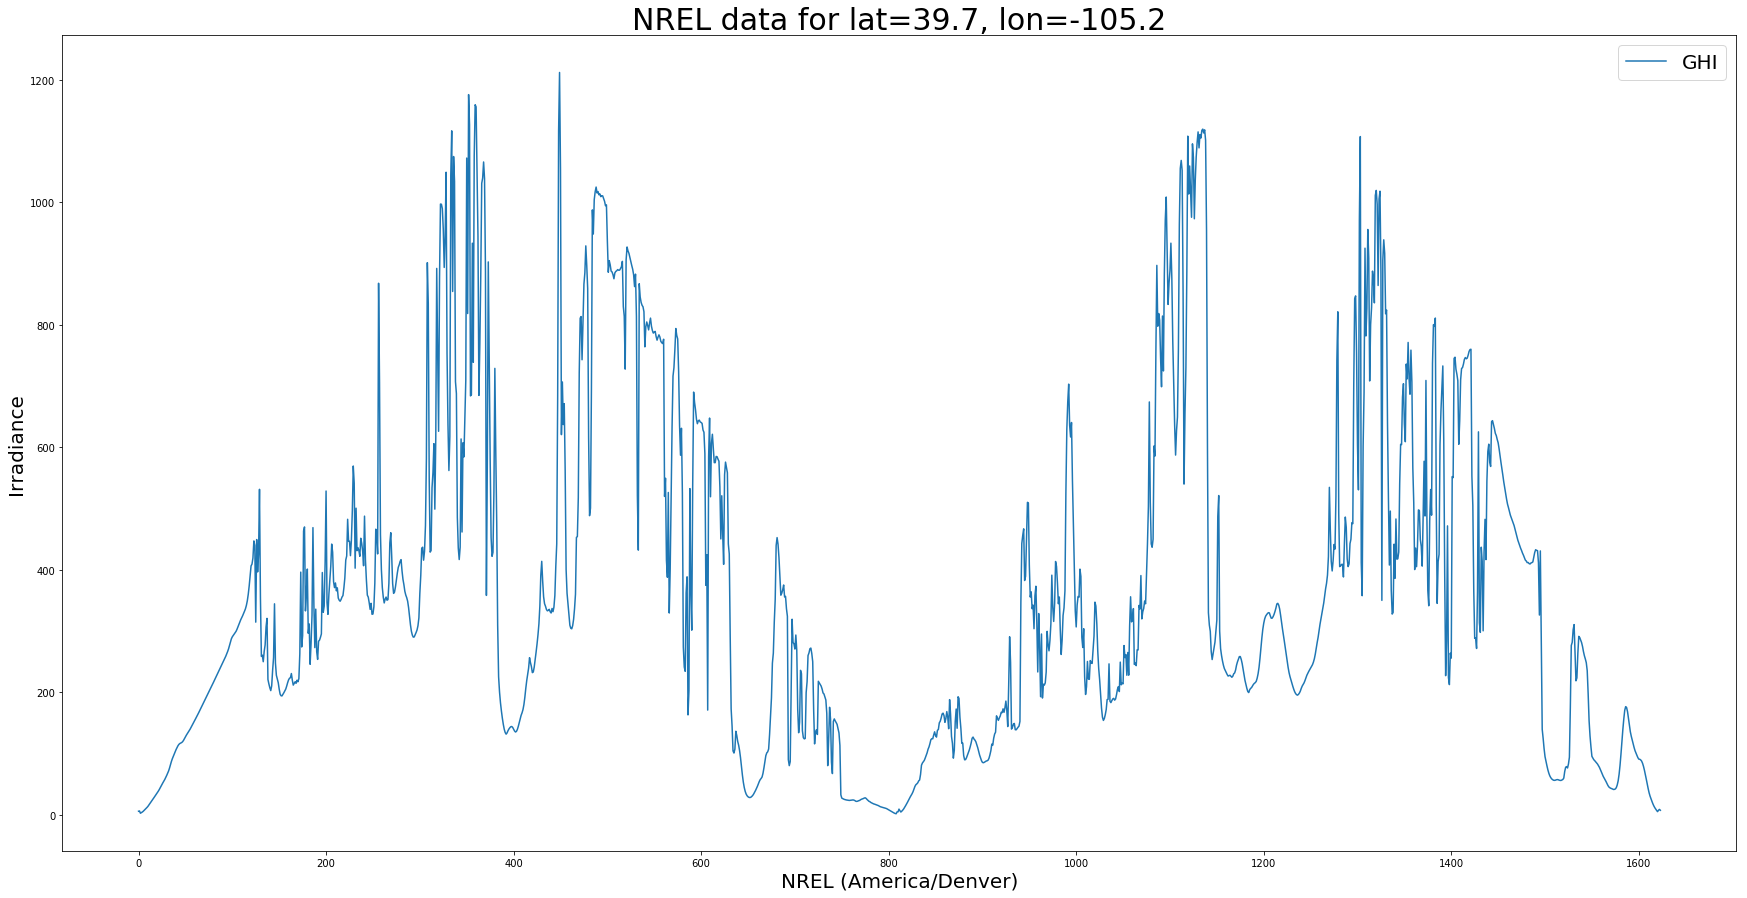

In [189]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

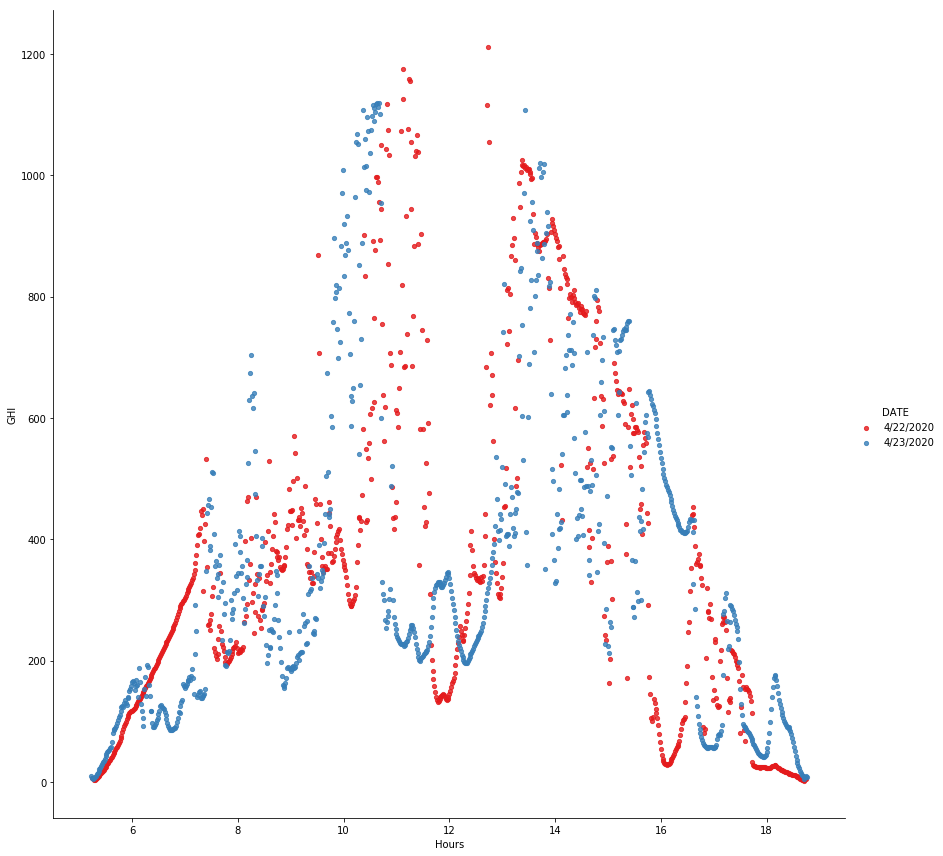

In [44]:
# Plot two parameters (GHI & Time)
sns.lmplot('Hours','GHI', data=nrel_df, hue='DATE', palette='Set1', markers="." ,fit_reg=False, scatter_kws={"s": 70}, height=12);

In [166]:
nrel_df_slice = nrel_df.iloc[::90]

In [167]:
nrel_df_slice

,DATE,MST,Time,Hours,GHI,DHI,DNI,Air Temperature
0,4/22/2020,2020-04-28 05:15:00,05:15,5.250000,6.18000,6.18000,0.0000,11.05
90,4/22/2020,2020-04-28 06:45:00,06:45,6.750000,249.32700,56.75270,671.7460,14.10
180,4/22/2020,2020-04-28 08:15:00,08:15,8.250000,401.46200,263.51200,247.7700,14.03
270,4/22/2020,2020-04-28 09:45:00,09:45,9.750000,422.47600,403.93200,24.2916,14.23
360,4/22/2020,2020-04-28 11:15:00,11:15,11.250000,1155.98000,472.25600,781.1160,16.09
450,4/22/2020,2020-04-28 12:45:00,12:45,12.750000,1054.37000,511.86500,620.0660,15.33
540,4/22/2020,2020-04-28 14:15:00,14:15,14.250000,764.18500,145.78100,811.1010,15.65
630,4/22/2020,2020-04-28 15:45:00,15:45,15.750000,426.20300,121.97700,547.8780,16.45
720,4/22/2020,2020-04-28 17:15:00,17:15,17.250000,171.52000,67.95840,363.4550,15.42
810,4/22/2020,2020-04-28 18:45:00,18:45,18.750000,5.14145,5.14145,0.0000,11.17


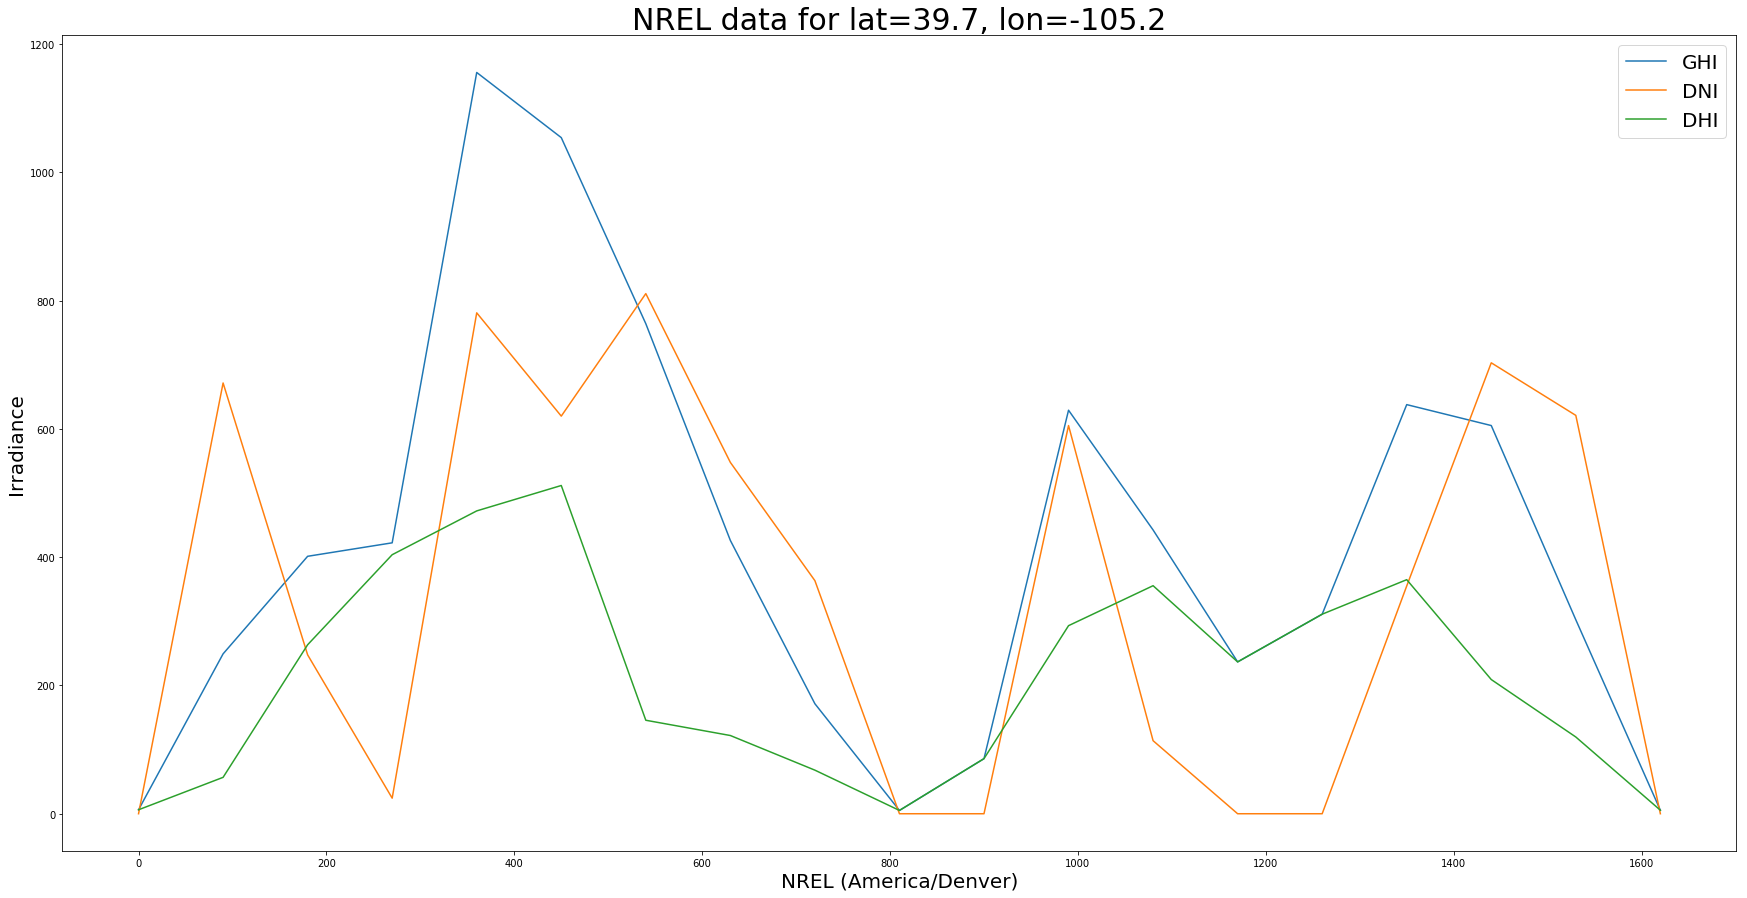

In [186]:
# Plot cloud cover percentages
irrad_var = ['GHI', 'DNI','DHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

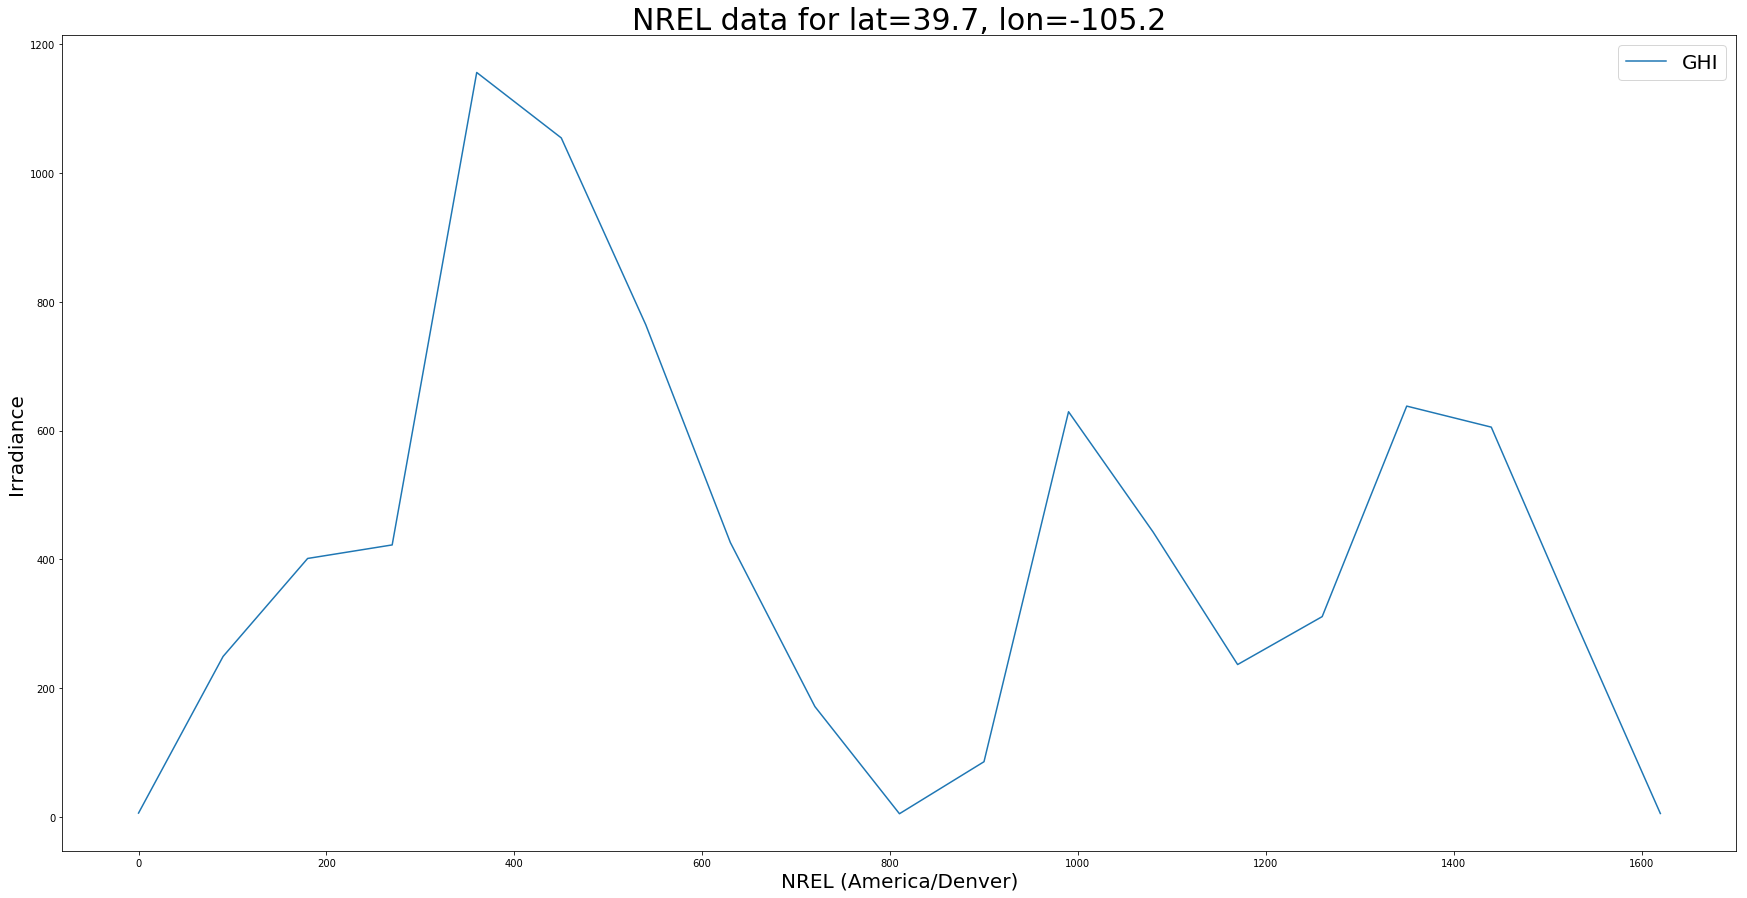

In [187]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [ ]:
# Plot cloud cover percentages
nrel_irrad = ['Global Horizontal', 'Direct Normal']
nrel_df[nrel_irrad].plot(figsize=(15,10));
plt.ylabel('C %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();


In [ ]:

# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

In [13]:
y=np.datetime64('MST').astype(datetime)
plot_date(y,2)

ValueError: Error parsing datetime string "MST" at position 0

TypeError: Could not convert 05:1605:1705:1805:1905:2005:2105:2205:2305:2405:2505:2605:2705:2805:2905:3005:3105:3205:3305:3405:3505:3605:3705:3805:3905:4005:4105:4205:4305:4405:4505:4605:4705:4805:4905:5005:5105:5205:5305:5405:5505:5605:5705:5805:5906:0006:0106:0206:0306:0406:0506:0606:0706:0806:0906:1006:1106:1206:1306:1406:1506:1606:1706:1806:1906:2006:2106:2206:2306:2406:2506:2606:2706:2806:2906:3006:3106:3206:3306:3406:3506:3606:3706:3806:3906:4006:4106:4206:4306:4406:4506:4606:4706:4806:4906:5006:5106:5206:5306:5406:5506:5606:5706:5806:5907:0007:0107:0207:0307:0407:0507:0607:0707:0807:0907:1007:1107:1207:1307:1407:1507:1607:1707:1807:1907:2007:2107:2207:2307:2407:2507:2607:2707:2807:2907:3007:3107:3207:3307:3407:3507:3607:3707:3807:3907:4007:4107:4207:4307:4407:4507:4607:4707:4807:4907:5007:5107:5207:5307:5407:5507:5607:5707:5807:5908:0008:0108:0208:0308:0408:0508:0608:0708:0808:0908:1008:1108:1208:1308:1408:1508:1608:1708:1808:1908:2008:2108:2208:2308:2408:2508:2608:2708:2808:2908:3008:3108:3208:3308:3408:3508:3608:3708:3808:3908:4008:4108:4208:4308:4408:4508:4608:4708:4808:4908:5008:5108:5208:5308:5408:5508:5608:5708:5808:5909:0009:0109:0209:0309:0409:0509:0609:0709:0809:0909:1009:1109:1209:1309:1409:1509:1609:1709:1809:1909:2009:2109:2209:2309:2409:2509:2609:2709:2809:2909:3009:3109:3209:3309:3409:3509:3609:3709:3809:3909:4009:4109:4209:4309:4409:4509:4609:4709:4809:4909:5009:5109:5209:5309:5409:5509:5609:5709:5809:5910:0010:0110:0210:0310:0410:0510:0610:0710:0810:0910:1010:1110:1210:1310:1410:1510:1610:1710:1810:1910:2010:2110:2210:2310:2410:2510:2610:2710:2810:2910:3010:3110:3210:3310:3410:3510:3610:3710:3810:3910:4010:4110:4210:4310:4410:4510:4610:4710:4810:4910:5010:5110:5210:5310:5410:5510:5610:5710:5810:5911:0011:0111:0211:0311:0411:0511:0611:0711:0811:0911:1011:1111:1211:1311:1411:1511:1611:1711:1811:1911:2011:2111:2211:2311:2411:2511:2611:2711:2811:2911:3011:3111:3211:3311:3411:3511:3611:3711:3811:3911:4011:4111:4211:4311:4411:4511:4611:4711:4811:4911:5011:5111:5211:5311:5411:5511:5611:5711:5811:5912:0012:0112:0212:0312:0412:0512:0612:0712:0812:0912:1012:1112:1212:1312:1412:1512:1612:1712:1812:1912:2012:2112:2212:2312:2412:2512:2612:2712:2812:2912:3012:3112:3212:3312:3412:3512:3612:3712:3812:3912:4012:4112:4212:4312:4412:4512:4612:4712:4812:4912:5012:5112:5212:5312:5412:5512:5612:5712:5812:5913:0013:0113:0213:0313:0413:0513:0613:0713:0813:0913:1013:1113:1213:1313:1413:1513:1613:1713:1813:1913:2013:2113:2213:2313:2413:2513:2613:2713:2813:2913:3013:3113:3213:3313:3413:3513:3613:3713:3813:3913:4013:4113:4213:4313:4413:4513:4613:4713:4813:4913:5013:5113:5213:5313:5413:5513:5613:5713:5813:5914:0014:0114:0214:0314:0414:0514:0614:0714:0814:0914:1014:1114:1214:1314:1414:1514:1614:1714:1814:1914:2014:2114:2214:2314:2414:2514:2614:2714:2814:2914:3014:3114:3214:3314:3414:3514:3614:3714:3814:3914:4014:4114:4214:4314:4414:4514:4614:4714:4814:4914:5014:5114:5214:5314:5414:5514:5614:5714:5814:5915:0015:0115:0215:0315:0415:0515:0615:0715:0815:0915:1015:1115:1215:1315:1415:1515:1615:1715:1815:1915:2015:2115:2215:2315:2415:2515:2615:2715:2815:2915:3015:3115:3215:3315:3415:3515:3615:3715:3815:3915:4015:4115:4215:4315:4415:4515:4615:4715:4815:4915:5015:5115:5215:5315:5415:5515:5615:5715:5815:5916:0016:0116:0216:0316:0416:0516:0616:0716:0816:0916:1016:1116:1216:1316:1416:1516:1616:1716:1816:1916:2016:2116:2216:2316:2416:2516:2616:2716:2816:2916:3016:3116:3216:3316:3416:3516:3616:3716:3816:3916:4016:4116:4216:4316:4416:4516:4616:4716:4816:4916:5016:5116:5216:5316:5416:5516:5616:5716:5816:5917:0017:0117:0217:0317:0417:0517:0617:0717:0817:0917:1017:1117:1217:1317:1417:1517:1617:1717:1817:1917:2017:2117:2217:2317:2417:2517:2617:2717:2817:2917:3017:3117:3217:3317:3417:3517:3617:3717:3817:3917:4017:4117:4217:4317:4417:4517:4617:4717:4817:4917:5017:5117:5217:5317:5417:5517:5617:5717:5817:5918:0018:0118:0218:0318:0418:0518:0618:0718:0818:0918:1018:1118:1218:1318:1418:1518:1618:1718:1818:1918:2018:2118:2218:2318:2418:2518:2618:2718:2818:2918:3018:3118:3218:3318:3418:3518:3618:3718:3818:3918:4018:4118:4218:4318:4405:1505:1605:1705:1805:1905:2005:2105:2205:2305:2405:2505:2605:2705:2805:2905:3005:3105:3205:3305:3405:3505:3605:3705:3805:3905:4005:4105:4205:4305:4405:4505:4605:4705:4805:4905:5005:5105:5205:5305:5405:5505:5605:5705:5805:5906:0006:0106:0206:0306:0406:0506:0606:0706:0806:0906:1006:1106:1206:1306:1406:1506:1606:1706:1806:1906:2006:2106:2206:2306:2406:2506:2606:2706:2806:2906:3006:3106:3206:3306:3406:3506:3606:3706:3806:3906:4006:4106:4206:4306:4406:4506:4606:4706:4806:4906:5006:5106:5206:5306:5406:5506:5606:5706:5806:5907:0007:0107:0207:0307:0407:0507:0607:0707:0807:0907:1007:1107:1207:1307:1407:1507:1607:1707:1807:1907:2007:2107:2207:2307:2407:2507:2607:2707:2807:2907:3007:3107:3207:3307:3407:3507:3607:3707:3807:3907:4007:4107:4207:4307:4407:4507:4607:4707:4807:4907:5007:5107:5207:5307:5407:5507:5607:5707:5807:5908:0008:0108:0208:0308:0408:0508:0608:0708:0808:0908:1008:1108:1208:1308:1408:1508:1608:1708:1808:1908:2008:2108:2208:2308:2408:2508:2608:2708:2808:2908:3008:3108:3208:3308:3408:3508:3608:3708:3808:3908:4008:4108:4208:4308:4408:4508:4608:4708:4808:4908:5008:5108:5208:5308:5408:5508:5608:5708:5808:5909:0009:0109:0209:0309:0409:0509:0609:0709:0809:0909:1009:1109:1209:1309:1409:1509:1609:1709:1809:1909:2009:2109:2209:2309:2409:2509:2609:2709:2809:2909:3009:3109:3209:3309:3409:3509:3609:3709:3809:3909:4009:4109:4209:4309:4409:4509:4609:4709:4809:4909:5009:5109:5209:5309:5409:5509:5609:5709:5809:5910:0010:0110:0210:0310:0410:0510:0610:0710:0810:0910:1010:1110:1210:1310:1410:1510:1610:1710:1810:1910:2010:2110:2210:2310:2410:2510:2610:2710:2810:2910:3010:3110:3210:3310:3410:3510:3610:3710:3810:3910:4010:4110:4210:4310:4410:4510:4610:4710:4810:4910:5010:5110:5210:5310:5410:5510:5610:5710:5810:5911:0011:0111:0211:0311:0411:0511:0611:0711:0811:0911:1011:1111:1211:1311:1411:1511:1611:1711:1811:1911:2011:2111:2211:2311:2411:2511:2611:2711:2811:2911:3011:3111:3211:3311:3411:3511:3611:3711:3811:3911:4011:4111:4211:4311:4411:4511:4611:4711:4811:4911:5011:5111:5211:5311:5411:5511:5611:5711:5811:5912:0012:0112:0212:0312:0412:0512:0612:0712:0812:0912:1012:1112:1212:1312:1412:1512:1612:1712:1812:1912:2012:2112:2212:2312:2412:2512:2612:2712:2812:2912:3012:3112:3212:3312:3412:3512:3612:3712:3812:3912:4012:4112:4212:4312:4412:4512:4612:4712:4812:4912:5012:5112:5212:5312:5412:5512:5612:5712:5812:5913:0013:0113:0213:0313:0413:0513:0613:0713:0813:0913:1013:1113:1213:1313:1413:1513:1613:1713:1813:1913:2013:2113:2213:2313:2413:2513:2613:2713:2813:2913:3013:3113:3213:3313:3413:3513:3613:3713:3813:3913:4013:4113:4213:4313:4413:4513:4613:4713:4813:4913:5013:5113:5213:5313:5413:5513:5613:5713:5813:5914:0014:0114:0214:0314:0414:0514:0614:0714:0814:0914:1014:1114:1214:1314:1414:1514:1614:1714:1814:1914:2014:2114:2214:2314:2414:2514:2614:2714:2814:2914:3014:3114:3214:3314:3414:3514:3614:3714:3814:3914:4014:4114:4214:4314:4414:4514:4614:4714:4814:4914:5014:5114:5214:5314:5414:5514:5614:5714:5814:5915:0015:0115:0215:0315:0415:0515:0615:0715:0815:0915:1015:1115:1215:1315:1415:1515:1615:1715:1815:1915:2015:2115:2215:2315:2415:2515:2615:2715:2815:2915:3015:3115:3215:3315:3415:3515:3615:3715:3815:3915:4015:4115:4215:4315:4415:4515:4615:4715:4815:4915:5015:5115:5215:5315:5415:5515:5615:5715:5815:5916:0016:0116:0216:0316:0416:0516:0616:0716:0816:0916:1016:1116:1216:1316:1416:1516:1616:1716:1816:1916:2016:2116:2216:2316:2416:2516:2616:2716:2816:2916:3016:3116:3216:3316:3416:3516:3616:3716:3816:3916:4016:4116:4216:4316:4416:4516:4616:4716:4816:4916:5016:5116:5216:5316:5416:5516:5616:5716:5816:5917:0017:0117:0217:0317:0417:0517:0617:0717:0817:0917:1017:1117:1217:1317:1417:1517:1617:1717:1817:1917:2017:2117:2217:2317:2417:2517:2617:2717:2817:2917:3017:3117:3217:3317:3417:3517:3617:3717:3817:3917:4017:4117:4217:4317:4417:4517:4617:4717:4817:4917:5017:5117:5217:5317:5417:5517:5617:5717:5817:5918:0018:0118:0218:0318:0418:0518:0618:0718:0818:0918:1018:1118:1218:1318:1418:1518:1618:1718:1818:1918:2018:2118:2218:2318:2418:2518:2618:2718:2818:2918:3018:3118:3218:3318:3418:3518:3618:3718:3818:3918:4018:4118:4218:4318:4418:4505:1405:1505:1605:1705:1805:1905:2005:2105:2205:2305:2405:2505:2605:2705:2805:2905:3005:3105:3205:3305:3405:3505:3605:3705:3805:3905:4005:4105:4205:4305:4405:4505:4605:4705:4805:4905:5005:5105:5205:5305:5405:5505:5605:5705:5805:5906:0006:0106:0206:0306:0406:0506:0606:0706:0806:0906:1006:1106:1206:1306:1406:1506:1606:1706:1806:1906:2006:2106:2206:2306:2406:2506:2606:2706:2806:2906:3006:3106:3206:3306:3406:3506:3606:3706:3806:3906:4006:4106:4206:4306:4406:4506:4606:4706:4806:4906:5006:5106:5206:5306:5406:5506:5606:5706:5806:5907:0007:0107:0207:0307:0407:0507:0607:0707:0807:0907:1007:1107:1207:1307:1407:1507:1607:1707:1807:1907:2007:2107:2207:2307:2407:2507:2607:2707:2807:2907:3007:3107:3207:3307:3407:3507:3607:3707:3807:3907:4007:4107:4207:4307:4407:4507:4607:4707:4807:4907:5007:5107:5207:5307:5407:5507:5607:5707:5807:5908:0008:0108:0208:0308:0408:0508:0608:0708:0808:0908:1008:1108:1208:1308:1408:1508:1608:1708:1808:1908:2008:2108:2208:2308:2408:2508:2608:2708:2808:2908:3008:3108:3208:3308:3408:3508:3608:3708:3808:3908:4008:4108:4208:4308:4408:4508:4608:4708:4808:4908:5008:5108:5208:5308:5408:5508:5608:5708:5808:5909:0009:0109:0209:0309:0409:0509:0609:0709:0809:0909:1009:1109:1209:1309:1409:1509:1609:1709:1809:1909:2009:2109:2209:2309:2409:2509:2609:2709:2809:2909:3009:3109:3209:3309:3409:3509:3609:3709:3809:3909:4009:4109:4209:4309:4409:4509:4609:4709:4809:4909:5009:5109:5209:5309:5409:5509:5609:5709:5809:5910:0010:0110:0210:0310:0410:0510:0610:0710:0810:0910:1010:1110:1210:1310:1410:1510:1610:1710:1810:1910:2010:2110:2210:2310:2410:2510:2610:2710:2810:2910:3010:3110:3210:3310:3410:3510:3610:3710:3810:3910:4010:4110:4210:4310:4410:4510:4610:4710:4810:4910:5010:5110:5210:5310:5410:5510:5610:5710:5810:5911:0011:0111:0211:0311:0411:0511:0611:0711:0811:0911:1011:1111:1211:1311:1411:1511:1611:1711:1811:1911:2011:2111:2211:2311:2411:2511:2611:2711:2811:2911:3011:3111:3211:3311:3411:3511:3611:3711:3811:3911:4011:4111:4211:4311:4411:4511:4611:4711:4811:4911:5011:5111:5211:5311:5411:5511:5611:5711:5811:5912:0012:0112:0212:0312:0412:0512:0612:0712:0812:0912:1012:1112:1212:1312:1412:1512:1612:1712:1812:1912:2012:2112:2212:2312:2412:2512:2612:2712:2812:2912:3012:3112:3212:3312:3412:3512:3612:3712:3812:3912:4012:4112:4212:4312:4412:4512:4612:4712:4812:4912:5012:5112:5212:5312:5412:5512:5612:5712:5812:5913:0013:0113:0213:0313:0413:0513:0613:0713:0813:0913:1013:1113:1213:1313:1413:1513:1613:1713:1813:1913:2013:2113:2213:2313:2413:2513:2613:2713:2813:2913:3013:3113:3213:3313:3413:3513:3613:3713:3813:3913:4013:4113:4213:4313:4413:4513:4613:4713:4813:4913:5013:5113:5213:5313:5413:5513:5613:5713:5813:5914:0014:0114:0214:0314:0414:0514:0614:0714:0814:0914:1014:1114:1214:1314:1414:1514:1614:1714:1814:1914:2014:2114:2214:2314:2414:2514:2614:2714:2814:2914:3014:3114:3214:3314:3414:3514:3614:3714:3814:3914:4014:4114:4214:4314:4414:4514:4614:4714:4814:4914:5014:5114:5214:5314:5414:5514:5614:5714:5814:5915:0015:0115:0215:0315:0415:0515:0615:0715:0815:0915:1015:1115:1215:1315:1415:1515:1615:1715:1815:1915:2015:2115:2215:2315:2415:2515:2615:2715:2815:2915:3015:3115:3215:3315:3415:3515:3615:3715:3815:3915:4015:4115:4215:4315:4415:4515:4615:4715:4815:4915:5015:5115:5215:5315:5415:5515:5615:5715:5815:5916:0016:0116:0216:0316:0416:0516:0616:0716:0816:0916:1016:1116:1216:1316:1416:1516:1616:1716:1816:1916:2016:2116:2216:2316:2416:2516:2616:2716:2816:2916:3016:3116:3216:3316:3416:3516:3616:3716:3816:3916:4016:4116:4216:4316:4416:4516:4616:4716:4816:4916:5016:5116:5216:5316:5416:5516:5616:5716:5816:5917:0017:0117:0217:0317:0417:0517:0617:0717:0817:0917:1017:1117:1217:1317:1417:1517:1617:1717:1817:1917:2017:2117:2217:2317:2417:2517:2617:2717:2817:2917:3017:3117:3217:3317:3417:3517:3617:3717:3817:3917:4017:4117:4217:4317:4417:4517:4617:4717:4817:4917:5017:5117:5217:5317:5417:5517:5617:5717:5817:5918:0018:0118:0218:0318:0418:0518:0618:0718:0818:0918:1018:1118:1218:1318:1418:1518:1618:1718:1818:1918:2018:2118:2218:2318:2418:2518:2618:2718:2818:2918:3018:3118:3218:3318:3418:3518:3618:3718:3818:3918:4018:4118:4218:4318:4418:4518:46 to numeric

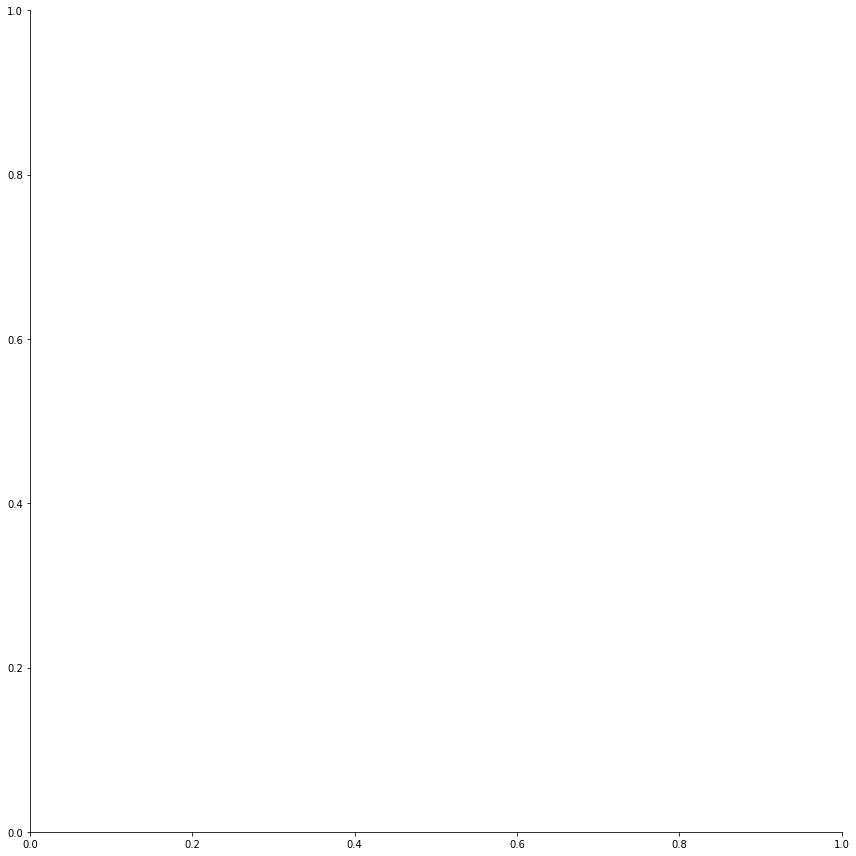

In [30]:
# Plot two parameters (Power & Irradiance)
sns.lmplot('Global Horizontal','Time', data=nrel_df, hue='DATE',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70}, height=12);

In [ ]:
# Visualize the relationship between Power Generated and Weather using scatterplots
sns.pairplot(nrel_df, x_vars=['Time','Irradiance', 'Temperature','CloudCover'], y_vars='Power', height=9, aspect=0.8, kind='reg')